In [5]:

# ==== IMPORTS ====
# Required libraries
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LogNorm
from matplotlib import ticker, cm
from datetime import datetime
import tcpyPI
from tcpyPI import pi
import time
import sys

In [21]:
from pathlib import Path

repo_root = Path("..").resolve()  # go from python_notebooks/ up to repo root
import tcvpigpiv
from tcvpigpiv.vpigpiv_module import compute_gpiv_from_dataset

In [18]:
url = 'https://tds.gdex.ucar.edu/thredds/dodsC/files/d651067/b.e21.BSSP585smbb.f09_g17.CESM2-LE/atm/proc/tseries/month_1/Q/b.e21.BSSP585smbb.f09_g17.CESM2-LE.001.cam.h0.Q.201501-206412.nc'
Q = xr.open_dataset(url).Q.isel(time=-1)

url = 'https://tds.gdex.ucar.edu/thredds/dodsC/files/d651067/b.e21.BSSP585smbb.f09_g17.CESM2-LE/atm/proc/tseries/month_1/T/b.e21.BSSP585smbb.f09_g17.CESM2-LE.001.cam.h0.T.201501-206412.nc'
T = xr.open_dataset(url).T.isel(time=-1)

url = 'https://tds.gdex.ucar.edu/thredds/dodsC/files/d651067/b.e21.BSSP585smbb.f09_g17.CESM2-LE/atm/proc/tseries/month_1/U/b.e21.BSSP585smbb.f09_g17.CESM2-LE.001.cam.h0.U.201501-206412.nc'
U = xr.open_dataset(url).U.isel(time=-1)

url = 'https://tds.gdex.ucar.edu/thredds/dodsC/files/d651067/b.e21.BSSP585smbb.f09_g17.CESM2-LE/atm/proc/tseries/month_1/V/b.e21.BSSP585smbb.f09_g17.CESM2-LE.001.cam.h0.V.201501-206412.nc'
V = xr.open_dataset(url).V.isel(time=-1)

url = 'https://tds.gdex.ucar.edu/thredds/dodsC/files/d651067/b.e21.BSSP585smbb.f09_g17.CESM2-LE/atm/proc/tseries/month_1/PS/b.e21.BSSP585smbb.f09_g17.CESM2-LE.001.cam.h0.PS.201501-206412.nc'
SP = xr.open_dataset(url).PS.isel(time=-1)

url = 'https://tds.gdex.ucar.edu/thredds/dodsC/files/d651067/b.e21.BSSP585smbb.f09_g17.CESM2-LE/atm/proc/tseries/month_1/SST/b.e21.BSSP585smbb.f09_g17.CESM2-LE.001.cam.h0.SST.201501-206412.nc'
SST = xr.open_dataset(url).SST.isel(time=-1)

R_earth = 6371e3
lat_rad = np.deg2rad(U.lat)

dx = R_earth * np.cos(lat_rad) * np.deg2rad(U.lon.diff('lon'))
dy = R_earth * np.deg2rad(U.lat.diff('lat'))


VO = V.differentiate('lon')/dx - U.differentiate('lat')/dy





In [19]:

ds = xr.merge([Q,T,U,V,SP.rename('SP'),SST.rename('SSTK'),VO.rename('VO')]).rename({'lev':'level','lat':'latitude','lon':'longitude'})
lev_coords = np.sort(np.array((ds.level.values.tolist() + [850,600,200])))[::-1]

# ds = ds.reindex(level=list(reversed(ds.level))).interp
ds = ds.interp(level=lev_coords)


In [20]:
results_ds = compute_gpiv_from_dataset(ds)


  Calculating Potential Intensity (PI)...
  Calculating Vertical Wind Shear (VWS)...
  Calculating Entropy Deficit (Chi)...
T600: min = 228.63147899976005 , max = 281.8082402028122
rv600: min = 0.00010334291313386652 , max = 0.008830617399271077
sm_600: min = -30.97498814846878 , max = 251.94101979518135
sm_star_600: min = -30.909928860264934 , max = 288.5377431614126
numerator type: <class 'numpy.ndarray'>
asdeq type: <class 'xarray.core.dataarray.DataArray'>
numerator dtype: float64
asdeq dtype: float64
  Calculating Capped Vorticity (eta_c)...
  Combining components for final GPIv...


/home/akruskie/.conda/envs/py39/lib/python3.9/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


In [5]:
vPI = results_ds.vPI
PI = results_ds.PI

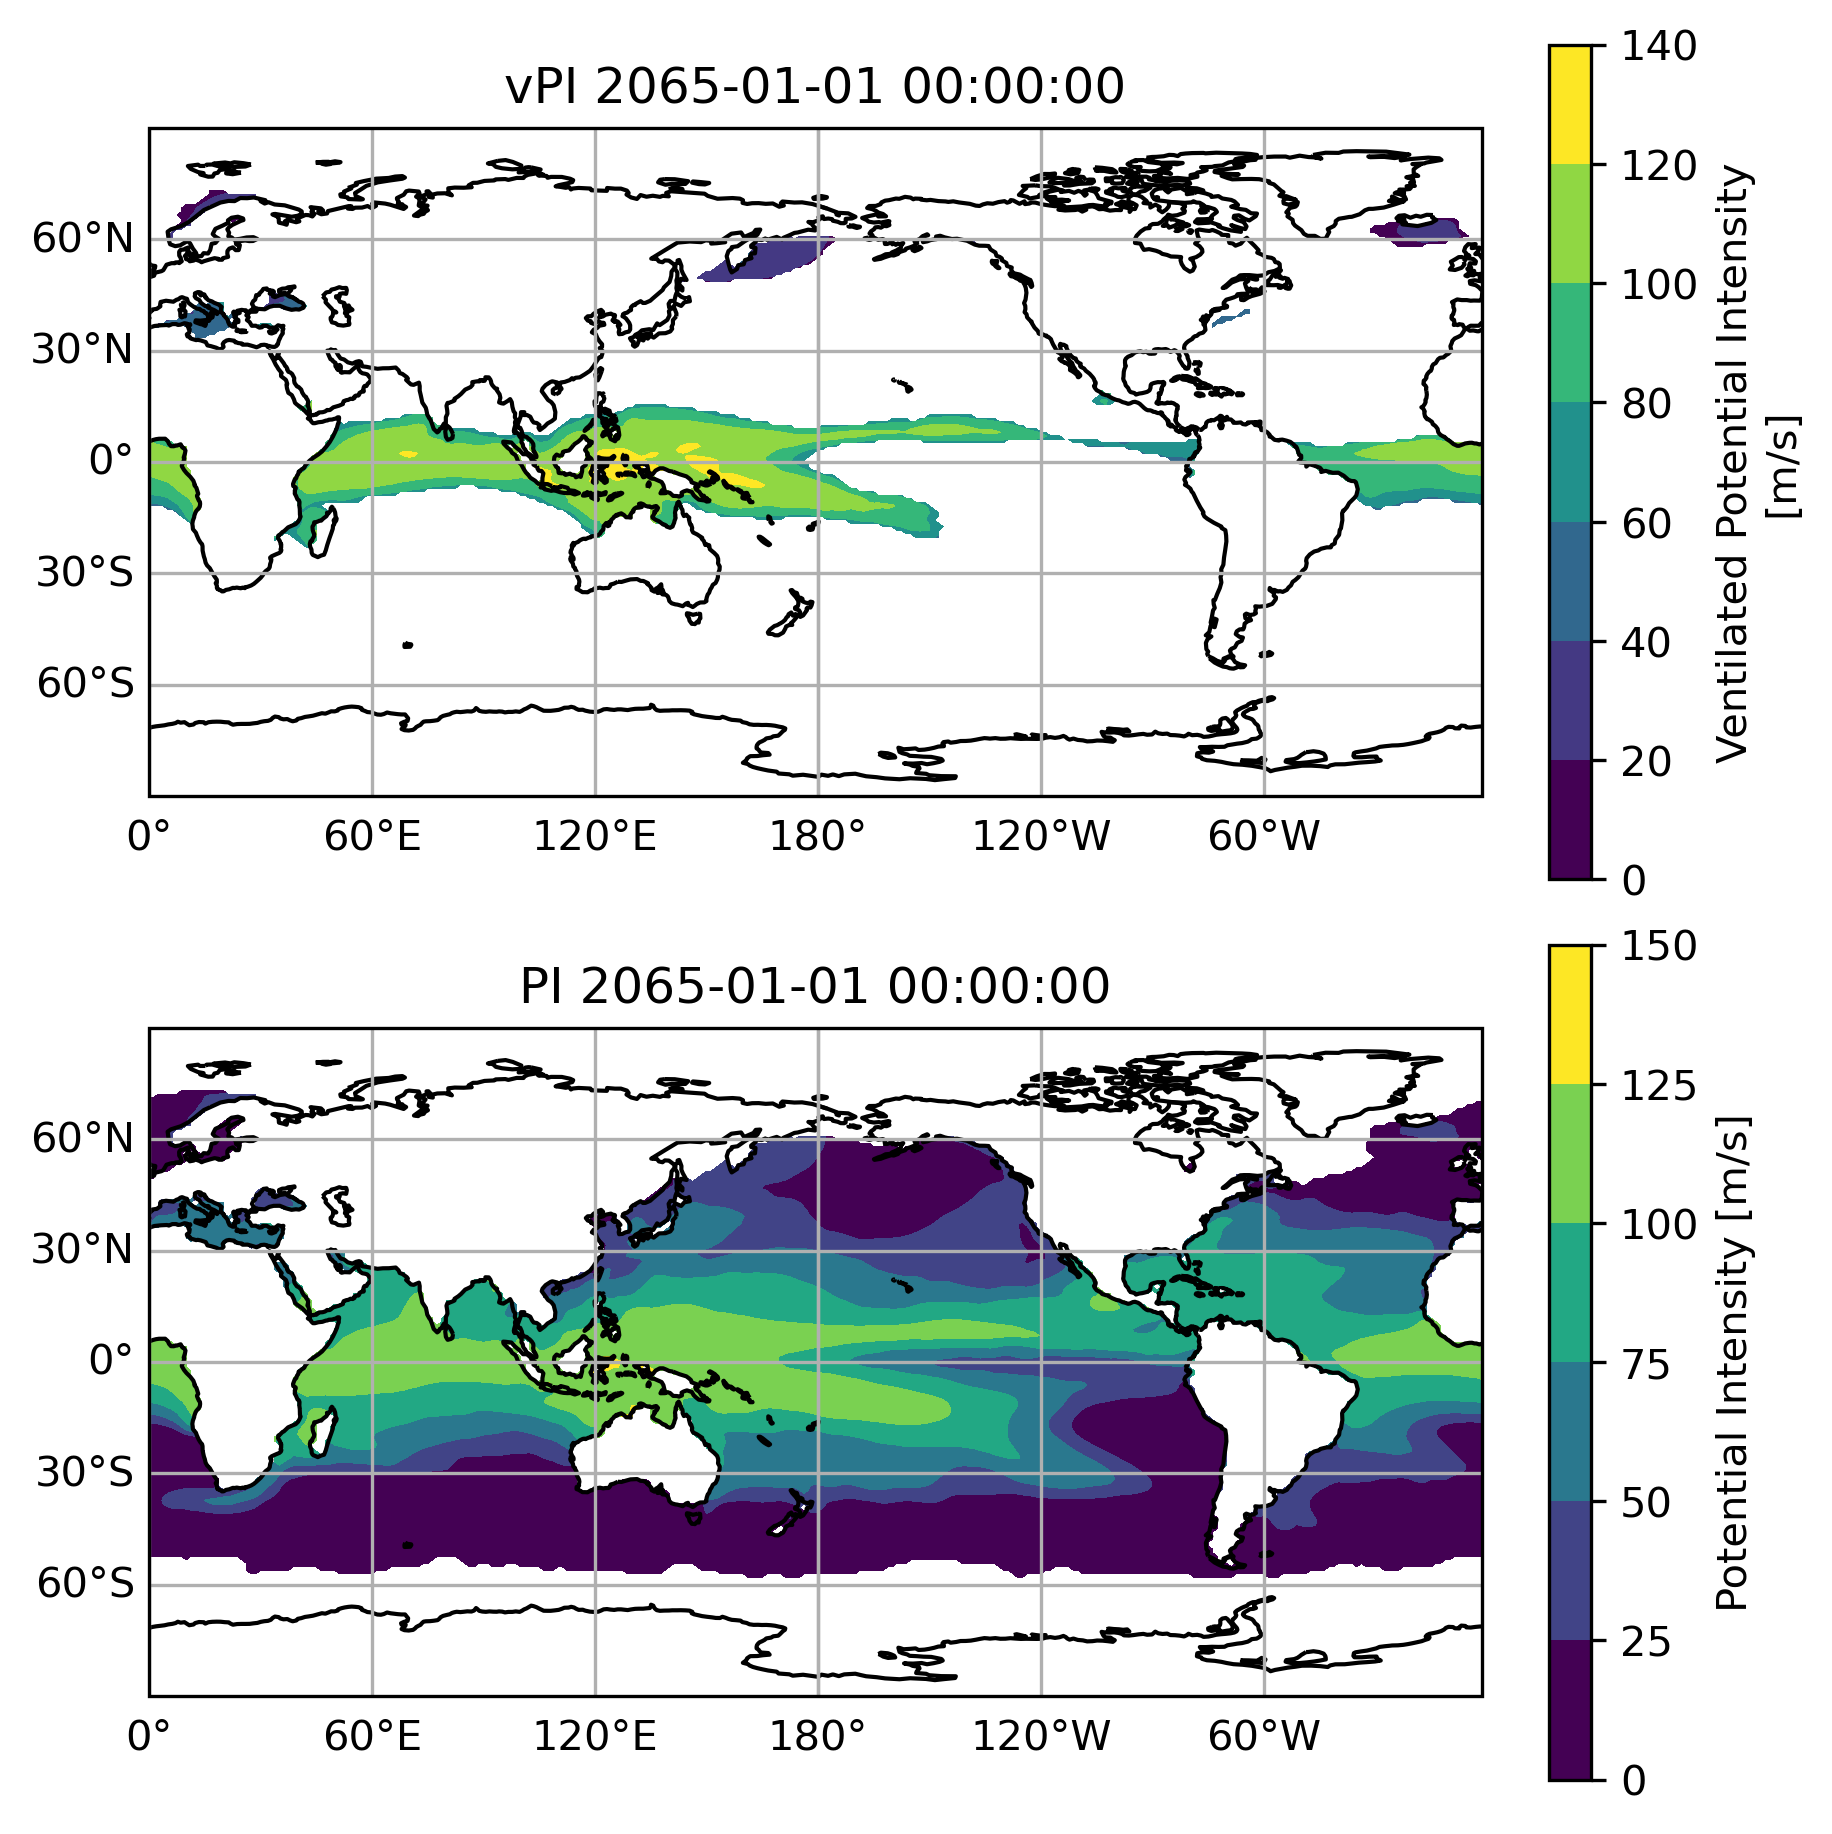

In [6]:
centlong=180
fig, ax = plt.subplots(2,figsize=(6, 6),constrained_layout=True,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=centlong)},dpi=300)  

xr.plot.contourf(vPI,ax=ax[0],transform=ccrs.PlateCarree())
ax[0].set_title(f"vPI {ds.time.values}" )
ax[0].coastlines()
gl=ax[0].gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

xr.plot.contourf(PI,ax=ax[1],transform=ccrs.PlateCarree())
ax[1].set_title(f"PI {ds.time.values}")
ax[1].coastlines()
gl=ax[1].gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False